In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import copy
from sklearn import preprocessing
from comut import comut
from statsmodels.stats import multitest
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from statsmodels.stats.multitest import multipletests


import warnings
warnings.filterwarnings('ignore')

root = f'/home/gmoorhea/Chaudhary_Moorhead_Head-Neck_ClinCanRes_Manuscript_2025/'

plt.rcParams["figure.figsize"] = (12,7)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['figure.dpi'] = 150
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
treat_colors = {'No Response' : 'blue','Response' : 'orangered'}

import matplotlib.pyplot as plt

In [3]:
'''
colors
'''
import palettable as pal

clinC = pal.cartocolors.qualitative.Vivid_10.mpl_colors

mappings = {}

clinvars = ['Positive', 'No Response', 'MHC-Intact', 'Negative', 'MHC-LOH', 'Response', 'No Prior IO', 'Prior IO', 'History of smoking', 'No history of smoking']
mappings['clinical'] = {clinvars[q]:clinC[q] for q in range(len(clinvars))} | {'Not Assessed':{'facecolor': 'grey', 'alpha': 0.2}}
mappings['clinical']['Response'] = 'tab:green'
mappings['clinical'] = mappings['clinical'] | {'cohort A': 'lightseagreen', 'cohort B':'crimson'}

In [4]:
'''
loading data
'''

df = pd.read_csv('../data/participant_annotations.tsv', sep='\t')

df.head(2)

,participant,analysis_id,treatment_response,hpv_status,smoking_status,prior_therapy,cohort
0,MCC072,M072-NR,No Response,Negative,History of smoking,No Prior IO,cohort B
1,MCC082,M082-NR,No Response,Negative,History of smoking,No Prior IO,cohort B


In [5]:
'''
creating hpv counts and pvals
'''

C_hpv = pd.DataFrame()
Pval_hpv = pd.DataFrame()

cohorts = [['cohort A', 'cohort B'], ['cohort B'], ['cohort A']]
cohort_labels = ['All', 'Cohort B', 'Cohort A']
responses = ['Response', 'No Response']

for cohort, cohort_label in zip(cohorts, cohort_labels):
    
    for resp in responses:
        hpv = df[(df['treatment_response']==resp) & (df['cohort'].isin(cohort)) & (df['hpv_status']=='Positive')]['participant'].nunique()
        C_hpv.loc[f'{cohort_label}—{resp}—Positive', 'num_patients'] = hpv
        C_hpv.loc[f'{cohort_label}—{resp}—Negative', 'num_patients'] = df[(df['treatment_response']==resp) &  (df['cohort'].isin(cohort))]['participant'].nunique() - hpv

    fisher = [
        [C_hpv.loc[f'{cohort_label}—{q}—Positive', 'num_patients'] for q in responses],
        [df[df['treatment_response']==q]['participant'].nunique() - C_hpv.loc[f'{cohort_label}—{q}—Positive', 'num_patients'] for q in responses]
    ]

    Pval_hpv.loc[cohort_label, 'p'] = stats.fisher_exact(fisher)[1]


# FDR correction
Pval_hpv.loc[Pval_hpv.index!='All', 'q'] = multipletests(Pval_hpv.loc[Pval_hpv.index!='All', 'p'],method='fdr_bh')[1]

C_hpv['cohort'] = C_hpv.index.str.split('—').str[0]
C_hpv['response'] = C_hpv.index.str.split('—').str[1]
C_hpv['HPV Status'] = C_hpv.index.str.split('—').str[2]

C_hpv['cohort_sorting'] = C_hpv['cohort'].map({'All':0, 'Cohort B':1, 'Cohort A':2})
C_hpv = C_hpv.sort_values(['cohort_sorting', 'response', 'HPV Status'])

C_hpv.head()

,num_patients,cohort,response,HPV Status,cohort_sorting
All—No Response—Negative,22.0,All,No Response,Negative,0
All—No Response—Positive,30.0,All,No Response,Positive,0
All—Response—Negative,21.0,All,Response,Negative,0
All—Response—Positive,5.0,All,Response,Positive,0
Cohort B—No Response—Negative,9.0,Cohort B,No Response,Negative,1


In [6]:
Pval_hpv

,p,q
All,0.001598,NaN
Cohort B,0.361089,0.361089
Cohort A,0.012553,0.025105


In [7]:
'''
creating sums for normalization
'''

S_hpv = C_hpv.groupby(['cohort', 'HPV Status']).sum(numeric_only=True).reset_index().sort_values(['cohort_sorting', 'HPV Status'])

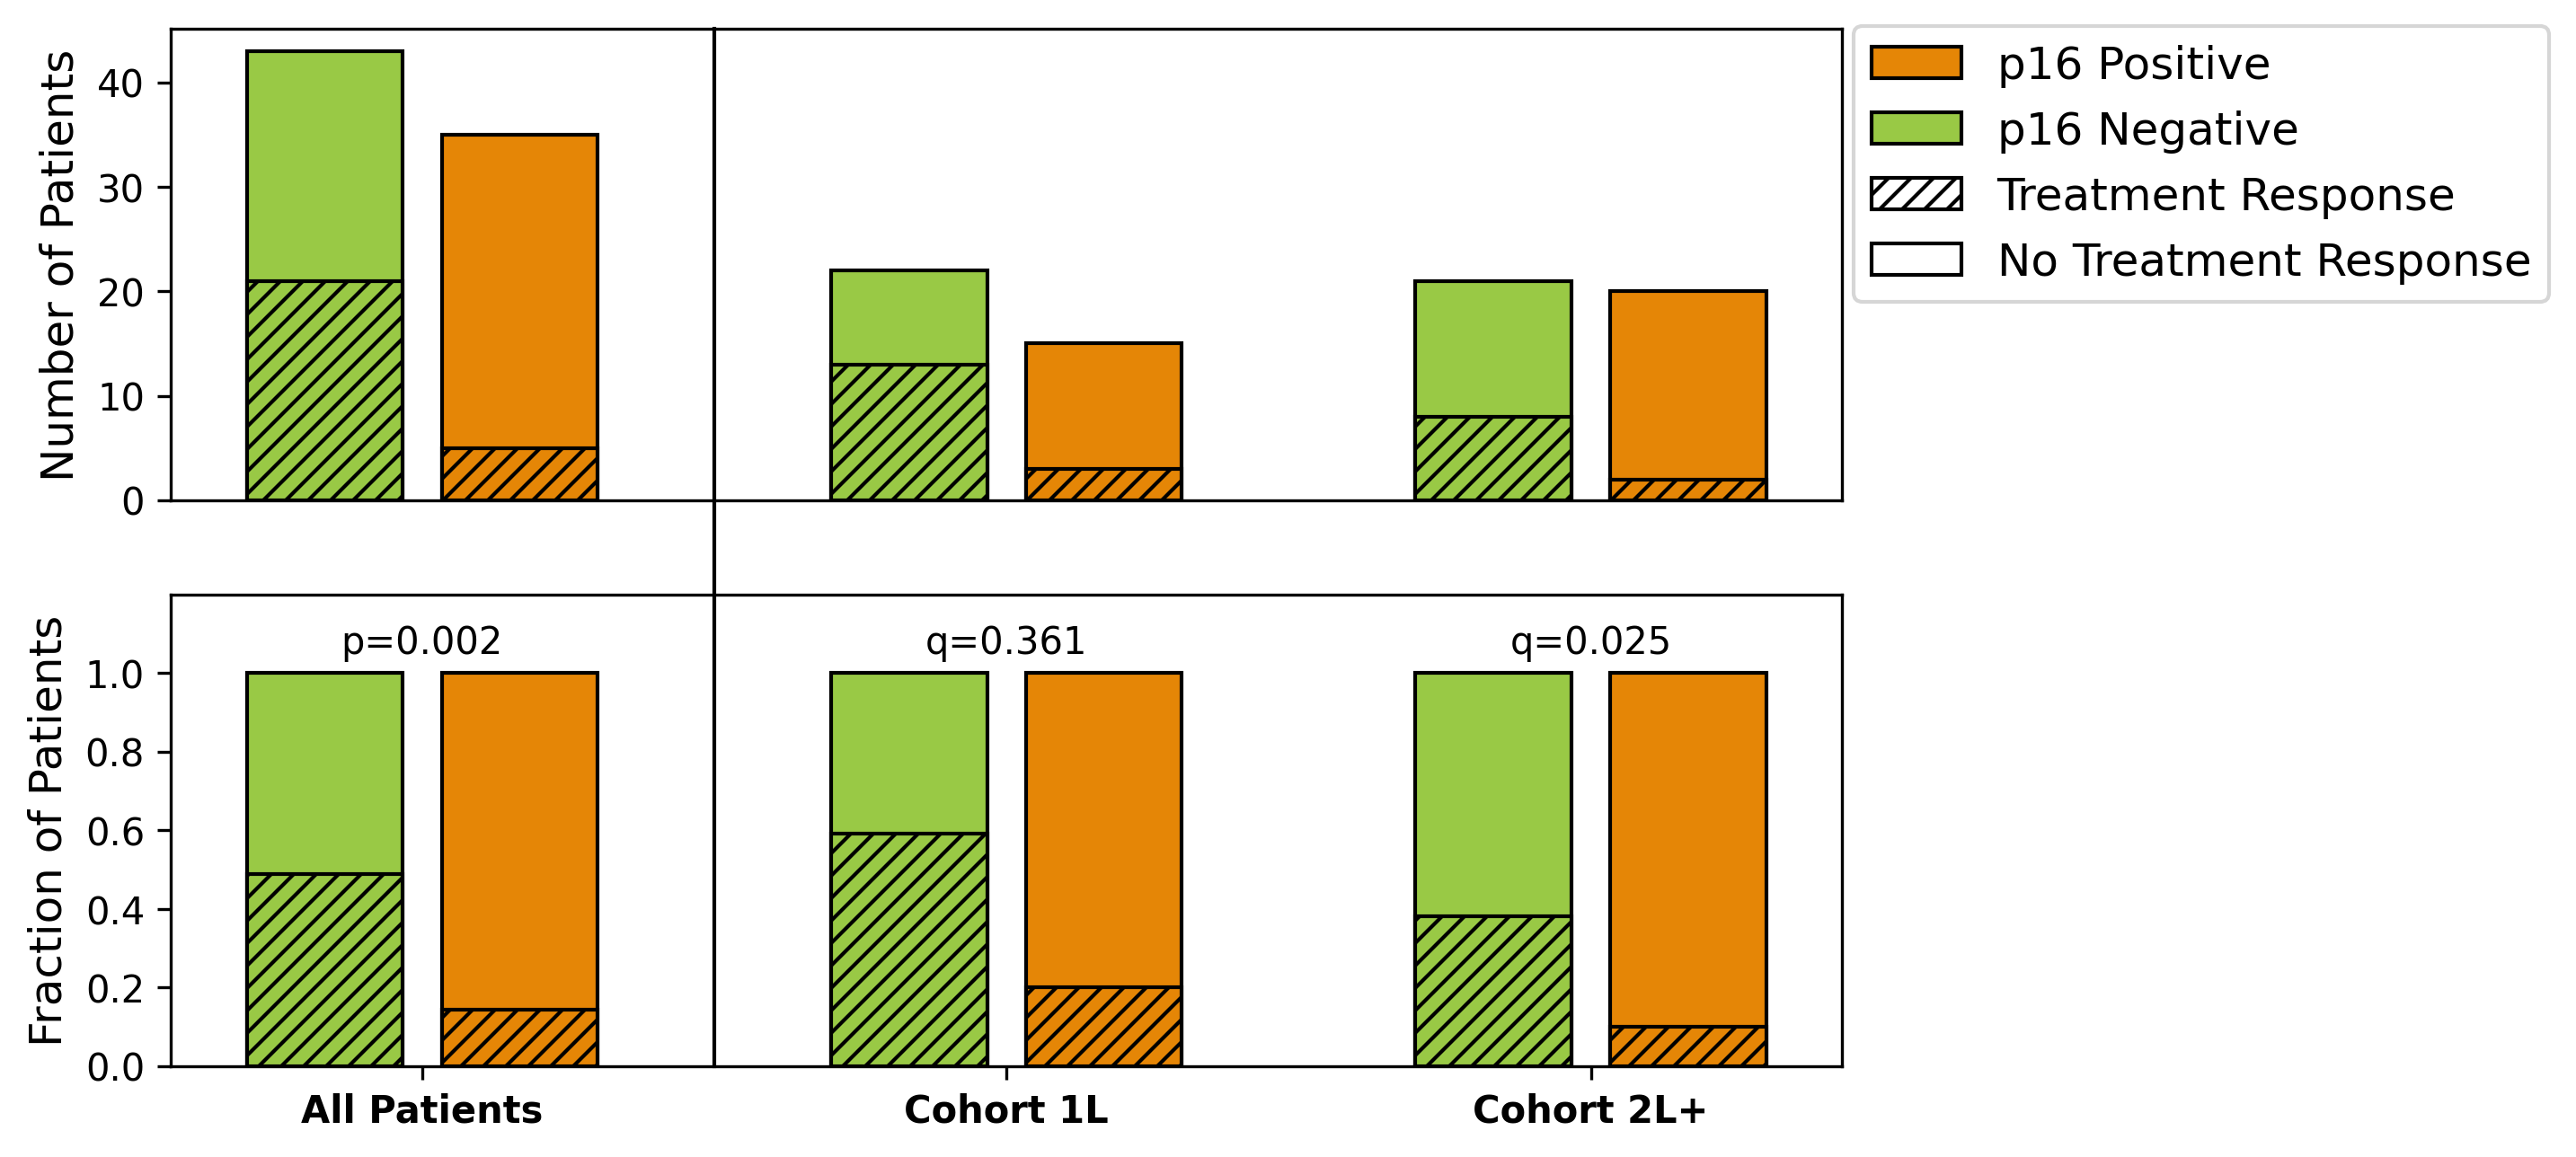

In [9]:
'''
plotting hpv
'''

Fig, Axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 5))


colors = C_hpv['HPV Status'].map(mappings['clinical']).drop_duplicates().tolist()
X = [1, 2, 4, 5, 7, 8]
xlocs = [1.5, 4.5, 7.5]

Axs[0].bar(x=X, height=np.array(C_hpv[C_hpv['response']=='No Response']['num_patients'])+np.array(C_hpv[C_hpv['response']=='Response']['num_patients']), color=colors, edgecolor='black')
Axs[0].bar(x=X, height=np.array(C_hpv[C_hpv['response']=='Response']['num_patients']), hatch=2*'//', color=colors, edgecolor='black')

Axs[0].set_ylabel('Number of Patients', fontsize=12)
Axs[0].set_xticks(ticks=[])


Axs[1].bar(x=X, height=(np.array(C_hpv[C_hpv['response']=='No Response']['num_patients'])+np.array(C_hpv[C_hpv['response']=='Response']['num_patients']))/np.array(S_hpv['num_patients']), color=colors, edgecolor='black')
Axs[1].bar(x=X, height=np.array(C_hpv[C_hpv['response']=='Response']['num_patients']) / np.array(S_hpv['num_patients']), hatch=2*'//', color=colors, edgecolor='black')

Axs[1].set_ylabel('Fraction of Patients', fontsize=12)

Axs[1].set_ylim(0, 1.2)
Axs[1].set_yticks(np.linspace(0, 1, 6))
for xloc, label in zip(xlocs, cohort_labels):
    Axs[1].annotate(xy=(xloc, 1.05), ha='center',
                    text=(f"q={round(Pval_hpv.loc[label, 'q'], 3)}" if not pd.isnull(Pval_hpv.loc[label, 'q']) else f"p={round(Pval_hpv.loc[label, 'p'], 3)}"))
    

# legend
legend_elements=[
    mpatches.Patch(facecolor=mappings['clinical']['Positive'], edgecolor='black', label='p16 Positive'),
    mpatches.Patch(facecolor=mappings['clinical']['Negative'], edgecolor='black', label='p16 Negative'),
    mpatches.Patch(facecolor='white', edgecolor='black', hatch=2*'//', label='Treatment Response'),
    mpatches.Patch(facecolor='white', edgecolor='black', label='No Treatment Response'),
]

Axs[0].legend(handles=legend_elements, loc='upper right', borderaxespad=1.0, fontsize=12, bbox_to_anchor=(1.45, 1.1))
Axs[1].axvline(3, ls='-', c='black', lw=1, ymax = 2.2, clip_on=False)

Axs[1].set_xticks(ticks=[1.5, 4.5, 7.5], labels=['All Patients', 'Cohort 1L', 'Cohort 2L+'], weight='semibold');